In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import astropy.units as u
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import eispac
import skimage
from skimage.measure import profile_line

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

In [6]:
eis_atlas_30_fex_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5"
eis_atlas_30_fexiv_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5"
eis_ch_fex_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
eis_ch_fexiv_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5"

In [7]:
eis_atlas_30_shiftx, eis_atlas_30_shifty = 4.5*u.arcsec, -4*u.arcsec
eis_ch_shiftx, eis_ch_shifty = -4.096*u.arcsec, -2.505*u.arcsec

eis_atlas_30_fex_fitres =  eispac.read_fit(eis_atlas_30_fex_filename)
eis_atlas_30_fex_intmap = eis_atlas_30_fex_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fex_intmap_shifted = eis_atlas_30_fex_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_atlas_30_fexiv_fitres =  eispac.read_fit(eis_atlas_30_fexiv_filename)
eis_atlas_30_fexiv_intmap = eis_atlas_30_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fexiv_intmap_shifted = eis_atlas_30_fexiv_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_ch_fex_fitres =  eispac.read_fit(eis_ch_fex_filename)
eis_ch_fex_intmap = eis_ch_fex_fitres.get_map(component=0, measurement='intensity')
eis_ch_fex_intmap_shifted = eis_ch_fex_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

eis_ch_fexiv_fitres =  eispac.read_fit(eis_ch_fexiv_filename)
eis_ch_fexiv_intmap = eis_ch_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_ch_fexiv_intmap_shifted = eis_ch_fexiv_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [8]:
eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


<SkyCoord (Helioprojective: obstime=2017-08-21T21:09:50.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T21:09:50.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (8.71063623e-15, 6.93331769, 1.51320798e+11)>): (Tx, Ty) in arcsec
    (-931.76660824, 328.22927856)>

In [9]:
green_frame_wavelength = CCDData.read(os.path.join(green_path,totality_green_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5", 'r') as hf:
    green_fit_matrix_ext = hf['green_fit_matrix_ext'][:]
    green_fit_matrix_ext_err = hf['green_fit_matrix_ext_err'][:]
    green_fit_matrix_bin_ext = hf['green_fit_matrix_bin_ext'][:]
    green_fit_matrix_bin_ext_err = hf['green_fit_matrix_bin_ext_err'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]
    green_fit_filename_index = hf['green_fit_filename_index'][:]

In [10]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [11]:
img_center = np.array([300,220])

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def plot_eis_fov(ax,eis_map,color="red",alpha=0.7,label="EIS"):
    eis_xstart = eis_map.bottom_left_coord.Tx.value
    eis_ystart = eis_map.bottom_left_coord.Ty.value
    eis_fovx = eis_map.dimensions.x * eis_map.scale.axis1
    eis_fovy = eis_map.dimensions.y * eis_map.scale.axis2
    rectangle = patches.Rectangle((eis_xstart, eis_ystart),
                            eis_fovx.value, eis_fovy.value,linewidth=2,edgecolor=color,
                            facecolor="none",alpha=alpha,label=label)
    ax.add_patch(rectangle)

In [12]:
FeXIV_xslice = slice(345,395)
pixel_size_green = np.abs(np.mean(np.diff((green_frame_wavelength/63./10.)[FeXIV_xslice])))
inst_width_pix_green = 1.86
inst_width_pix_err_green = 0.4
inst_width_nm_green = pixel_size_green*inst_width_pix_green
inst_width_nm_err_green = pixel_size_green*inst_width_pix_err_green

print(pixel_size_green, inst_width_nm_green)

0.02413460883717655 0.044890372437148385


In [13]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [14]:
mask_bad_fit_matrix_ext = np.where(np.any(np.abs(green_fit_matrix_ext_err/green_fit_matrix_ext)[:3,:,:] > 0.5,axis=0) | \
                np.any(np.isnan(green_fit_matrix_ext_err),axis=0))
mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(green_fit_matrix_bin_ext_err/green_fit_matrix_bin_ext)[:3,:,:] > 0.2,axis=0) | \
                np.any(np.isnan(green_fit_matrix_bin_ext_err),axis=0))

kernel = Gaussian2DKernel(x_stddev=1,y_stddev=2)
kernel_bin = Gaussian2DKernel(x_stddev=1,y_stddev=0.2)

green_where_disk_ext = np.where((x_2d_grid_green_arcsec_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)**2 < 970**2)

green_line_int_masked = np.copy(green_fit_matrix_ext[1,:,:])
# green_line_int_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_int_masked = interpolate_replace_nans(green_line_int_masked,kernel)
green_line_int_masked[green_where_disk_ext] = np.nan

green_line_int_masked_err = np.copy(green_fit_matrix_ext_err[1,:,:])
green_line_int_masked_err[green_where_disk_ext] = np.nan

green_cont_masked = np.copy(green_fit_matrix_ext[3,:,:]+green_fit_matrix_ext[4,:,:])
# green_cont_masked[mask_bad_fit_matrix_ext] = np.nan
# green_cont_masked = interpolate_replace_nans(green_cont_masked, kernel)
green_cont_masked[green_where_disk_ext] = np.nan

green_line_cont_ratio_masked = green_fit_matrix_ext[1,:,:]/(green_fit_matrix_ext[3,:,:]+green_fit_matrix_ext[4,:,:])
# green_line_cont_ratio_masked[mask_bad_fit_matrix_ext] = np.nan
# green_line_cont_ratio_masked = interpolate_replace_nans(green_line_cont_ratio_masked,kernel)
green_line_cont_ratio_masked[green_where_disk_ext] = np.nan

green_where_disk_bin_ext = np.where((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green)**2 + \
                                    (y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)**2 < 940**2)

green_vlos_masked = -(np.copy(green_fit_matrix_bin_ext[0,:,:]) - 530.29)/530.29*const.c.cgs.value*1e-5
green_vlos_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_vlos_masked[mask_bad_fit_matrix_bin_ext] = np.nan
green_vlos_masked[green_where_disk_bin_ext] = np.nan
green_vlos_masked = green_vlos_masked - np.nanmedian(green_vlos_masked)
# green_vlos_masked = interpolate_replace_nans(green_vlos_masked,kernel_bin)
green_vlos_masked[green_where_disk_bin_ext] = np.nan


green_fwhm_masked = np.copy(green_fit_matrix_bin_ext[2,:,:])
green_fwhm_masked[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked[mask_bad_fit_matrix_bin_ext] = np.nan
# green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan        
green_veff_masked = np.sqrt(green_fwhm_masked**2 - inst_width_nm_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
# green_veff_masked = interpolate_replace_nans(green_veff_masked,kernel_bin)
green_veff_masked[green_where_disk_bin_ext] = np.nan

green_fwhm_masked_err = np.copy(green_fit_matrix_bin_ext_err[2,:,:])
green_fwhm_masked_err[np.where(green_fit_matrix_bin_ext[1,:,:] < 15)] = np.nan
green_fwhm_masked_err[green_where_disk_bin_ext] = np.nan     
green_veff_masked_err = np.sqrt(green_fwhm_masked**2/(green_fwhm_masked**2 - inst_width_nm_green**2)* \
    green_fwhm_masked_err**2 + inst_width_nm_green**2/(green_fwhm_masked**2 - inst_width_nm_green**2)* \
    inst_width_nm_err_green**2)/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [16]:
def veff2teff(veff):
    return 55.85*const.u.cgs.value*(veff*1e5)**2/2/const.k_B.cgs.value/1e6

def teff2veff(teff):
    return np.sqrt(2*const.k_B.cgs.value*teff*1e6/(55.85*const.u.cgs.value))/1e5

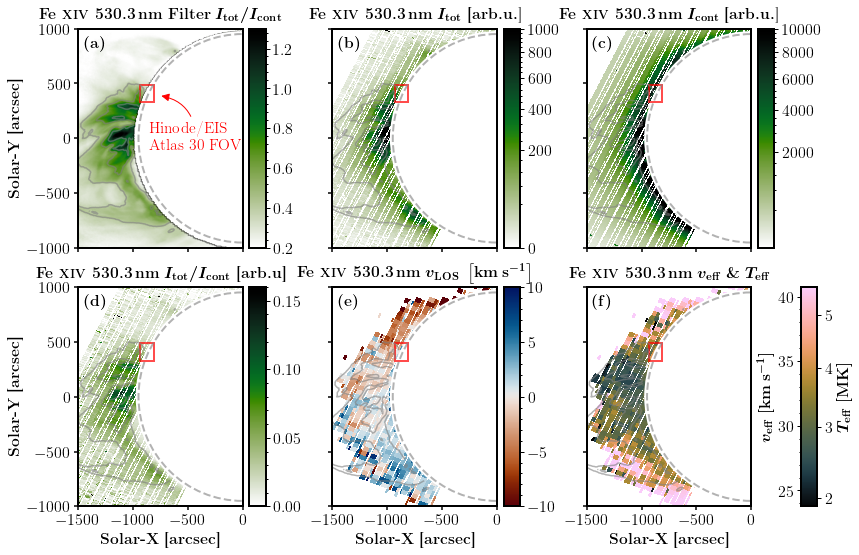

In [17]:
img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

colorbar_width = "10%"

def create_limb_circle(rsun):
    return patches.Circle((0,0),rsun,linewidth=2,edgecolor="grey",
                            facecolor="none",alpha=0.6,ls="--")

def create_lunar_mask(rmoon):
    return patches.Circle((0,0),rmoon,linewidth=0,edgecolor="none",
                            facecolor="white",alpha=1)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11,7.6),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.3,
                    cmap=cmr.jungle_r,shading="gouraud",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
ax1.annotate(r"Hinode/EIS" +"\n" + r"Atlas 30 FOV",(-760,390),(-850,-100),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.4","color":"red"},fontsize=16,color="red")

# for ax_ in (ax2,ax3,ax4,ax5,ax6):
#     ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.2,vmax=1.2,
#                     cmap=cmr.jungle_r,shading="gouraud",rasterized=True,alpha=0.5)

norm_green_line_int = ImageNormalize(data=green_line_int_masked,interval=ManualInterval(0,1000),stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_int_masked,cmap=cmr.jungle_r,rasterized=True,shading="auto",
                norm=norm_green_line_int)


plot_colorbar(im2, ax2,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

norm_green_cont_int = ImageNormalize(data=green_cont_masked,interval=ManualInterval(1e2,1e4),stretch=SqrtStretch())

im3 = ax3.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_cont_masked,cmap=cmr.jungle_r,rasterized=True,norm=norm_green_cont_int)

im3_clb, im3_clbax = plot_colorbar(im3, ax3,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
# im3_clbax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# im3_clbax.yaxis.get_offset_text().set_fontsize(16)
# im3_clbax.yaxis.get_offset_text().set(va="bottom",ha="left")
# im3_clbax.yaxis.get_offset_text().set_position((1,2))

im4 = ax4.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmr.jungle_r,rasterized=True,vmin=0,vmax=0.16)

plot_colorbar(im4, ax4,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im5 = ax5.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)


plot_colorbar(im5, ax5,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im6 = ax6.pcolormesh(x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green,
                green_veff_masked,cmap=cmcm.batlowK,rasterized=True,
                vmin=0.07/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
                ,vmax=0.12/530.29*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))


clb6, clb_ax6 = plot_colorbar(im6, ax6,width=colorbar_width,bbox_to_anchor=(1.3, 0., 1, 1),fontsize=16)
clb_ax6.yaxis.set_ticks_position("left")
clb_ax6.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=16)
clb_ax6.yaxis.set_label_position("left")
clb_ax6_teff = clb_ax6.secondary_yaxis("right",functions=(veff2teff, teff2veff))
clb_ax6_teff.tick_params(labelsize=16)
clb_ax6_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=16)


ax1.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax4.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax4.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax5.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax6.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)

ax1.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm Filter} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax2.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax3.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm cont}}$ \textbf{[arb.u.}]",fontsize=16,pad=10)
ax4.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$ \textbf{[arb.u]}",fontsize=16,pad=10)
ax5.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)
ax6.set_title(r"\textbf{Fe \textsc{xiv} 530.3\,nm} $\boldsymbol{v_{\rm eff}\ \&\ T_{\rm eff}}$",fontsize=16,pad=10)

for ax_, text_ in zip((ax1,ax2,ax3,ax4,ax5,ax6),
                      ("a","b","c","d","e","f")):
    ax_.text(0.035,0.97,r"\textbf{("+text_+r")}",fontsize=16,
             va="top",ha="left",transform=ax_.transAxes)

xlim_zoomin = [-1500,0]
ylim_zoomin = [-1000,1000]



for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,levels=[0.4,0.65,0.9],alpha=0.6,
            colors=['grey'])
    plot_eis_fov(ax_,eis_atlas_30_fexiv_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}") 
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16,which="both",width=1.5)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/ms/FeXIV_fit.pdf",dpi=300,format="pdf",bbox_inches="tight")

In [18]:
FeXIV_in_atlas30_FOV = np.where( \
((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green) > eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green) < eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Tx.value + 32) & \
((y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green) > eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green) < eis_atlas_30_fexiv_intmap_shifted.bottom_left_coord.Ty.value + 160))

In [19]:
green_veff_in_atlas30_FOV = green_veff_masked[FeXIV_in_atlas30_FOV]
green_veff_err_in_atlas30_FOV = green_veff_masked_err[FeXIV_in_atlas30_FOV]
green_veff_in_atlas30_FOV,green_veff_err_in_atlas30_FOV = np.unique([green_veff_in_atlas30_FOV,green_veff_err_in_atlas30_FOV],axis=1)
green_veff_in_atlas30_FOV = green_veff_in_atlas30_FOV[~np.isnan(green_veff_in_atlas30_FOV)]
green_veff_err_in_atlas30_FOV = green_veff_err_in_atlas30_FOV[~np.isnan(green_veff_err_in_atlas30_FOV)]

In [20]:
green_veff_in_atlas30_FOV, green_veff_err_in_atlas30_FOV

(array([29.70661373, 29.90392211, 32.11086826, 32.5963626 , 35.07219842]),
 array([1.74319856, 1.85044177, 1.70850746, 1.63099877, 1.71684443]))

In [21]:
green_veff_in_atlas30_aver = np.nansum(green_veff_in_atlas30_FOV/green_veff_err_in_atlas30_FOV**2)/np.nansum(1./green_veff_err_in_atlas30_FOV**2)
green_veff_in_atlas30_aver_err = np.sqrt(1./(green_veff_in_atlas30_FOV.shape[0] - 1)* \
(np.nansum(green_veff_in_atlas30_FOV**2/green_veff_err_in_atlas30_FOV**2)/np.nansum(1./green_veff_err_in_atlas30_FOV**2) - green_veff_in_atlas30_aver**2))

In [22]:
print("Average Fe XIV veff in Atlas 30 FOV: {:.2f} +/- {:.2f}".format(green_veff_in_atlas30_aver,green_veff_in_atlas30_aver_err))

Average Fe XIV veff in Atlas 30 FOV: 31.96 +/- 0.97


In [23]:
red_frame_wavelength = CCDData.read(os.path.join(red_path,totality_red_df_cut.iloc[0]["file"]),hdu=1,unit="adu").data

with h5py.File("../../sav/Eclipse/FitResults/FeX_52.h5", 'r') as hf:
    red_fit_matrix_ext = hf['red_fit_matrix_ext'][:]
    red_fit_matrix_ext_err = hf['red_fit_matrix_ext_err'][:]
    red_fit_matrix_bin_ext = hf['red_fit_matrix_bin_ext'][:]
    red_fit_matrix_bin_ext_err = hf['red_fit_matrix_bin_ext_err'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]
    red_fit_filename_index = hf['red_fit_filename_index'][:]

In [24]:
red_limb_loc = np.array([366.,592.,])
x_1d_grid_red_ext = np.arange(-51,125,1,dtype=np.float64) + 4
y_1d_grid_red_ext = np.arange(np.mean(red_limb_loc) - 699.,  np.mean(red_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_red_arcsec_ext = y_1d_grid_red_ext/(np.diff(red_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_red_arcsec_ext = x_1d_grid_red_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_red_arcsec_bin_ext = np.average(y_1d_grid_red_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_red_arcsec_ext, y_2d_grid_red_arcsec_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_ext)
x_2d_grid_red_arcsec_bin_ext, y_2d_grid_red_arcsec_bin_ext = np.meshgrid(x_1d_grid_red_arcsec_ext, y_1d_grid_red_arcsec_bin_ext)

y_red_step_correction_ext = (sun_y_fitpoly(np.linspace(0,87.5,176) - 4) - sun_y_fitpoly(66))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_red_step_correction_ext = np.flip(y_red_step_correction_ext)

y_2d_grid_red_arcsec_correct_ext = y_2d_grid_red_arcsec_ext + y_red_step_correction_ext[np.newaxis,:]
y_2d_grid_red_arcsec_bin_correct_ext = y_2d_grid_red_arcsec_bin_ext + y_red_step_correction_ext[np.newaxis,:]

x_2d_grid_red_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

y_2d_grid_red_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_correct_ext

x_2d_grid_red_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

y_2d_grid_red_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_red_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_red_arcsec_bin_correct_ext

In [25]:
FeX_xslice = slice(602,652)
pixel_size_red = np.abs(np.mean(np.diff((red_frame_wavelength/52/10.)[FeX_xslice])))
inst_width_pix_red = 2.12
inst_width_pix_err_red = 0.5
inst_width_nm_red = pixel_size_red*inst_width_pix_red
inst_width_nm_err_red = pixel_size_red*inst_width_pix_err_red

img_center = np.array([300,220])
img_xpixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXI_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

In [26]:
slit_xshift_red = sun_x_fitpoly(62) - slit_pos

slit_center_x_red =  - slit_xshift_red/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_red =  slit_xshift_red/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

In [27]:
red_mask_bad_fit_matrix_ext = np.where(np.any(np.abs(red_fit_matrix_ext_err/red_fit_matrix_ext)[:3,:,:] > 0.5,axis=0) | \
                np.any(np.isnan(red_fit_matrix_ext_err),axis=0))
red_mask_bad_fit_matrix_bin_ext = np.where(np.any(np.abs(red_fit_matrix_bin_ext_err/red_fit_matrix_bin_ext)[:3,:,:] > 0.2,axis=0) | \
                np.any(np.isnan(red_fit_matrix_bin_ext_err),axis=0))


red_where_disk_ext = np.where((x_2d_grid_red_arcsec_rot_ext + slit_center_x_red)**2 + \
                                    (y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)**2 < 970**2)

red_line_int_masked = np.copy(red_fit_matrix_ext[1,:,:])
# red_line_int_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_int_masked = interpolate_replace_nans(red_line_int_masked,kernel)
red_line_int_masked[red_where_disk_ext] = np.nan

red_line_int_masked_err = np.copy(red_fit_matrix_ext_err[1,:,:])
red_line_int_masked_err[red_where_disk_ext] = np.nan

red_cont_masked = np.copy(red_fit_matrix_ext[3,:,:]+red_fit_matrix_ext[4,:,:])
# red_cont_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_cont_masked = interpolate_replace_nans(red_cont_masked, kernel)
red_cont_masked[red_where_disk_ext] = np.nan

# red_line_cont_ratio_masked = red_fit_matrix_ext[1,:,:]/red_fit_matrix_ext[3,:,:]
# red_line_cont_ratio_masked[red_mask_bad_fit_matrix_ext] = np.nan
# red_line_cont_ratio_masked = interpolate_replace_nans(red_line_cont_ratio_masked,kernel)
# red_line_cont_ratio_masked[red_where_disk_ext] = np.nan
red_line_cont_ratio_masked = red_line_int_masked/red_cont_masked

red_where_disk_bin_ext = np.where((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + \
                                        (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2 < 940**2)

red_vlos_masked = -(np.copy(red_fit_matrix_bin_ext[0,:,:]) - 637.451)/637.451*const.c.cgs.value*1e-5
red_vlos_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked[red_where_disk_bin_ext] = np.nan
red_vlos_masked = red_vlos_masked - np.nanmedian(red_vlos_masked)
red_vlos_masked_err = red_fit_matrix_bin_ext_err[0,:,:]/637.451*const.c.cgs.value*1e-5
red_vlos_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 20)] = np.nan
red_vlos_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_vlos_masked_err[red_where_disk_bin_ext] = np.nan

red_fwhm_masked = np.copy(red_fit_matrix_bin_ext[2,:,:])
red_fwhm_masked[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked[red_where_disk_bin_ext] = np.nan
red_fwhm_masked[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err = np.copy(red_fit_matrix_bin_ext_err[2,:,:])
red_fwhm_masked_err[np.where(red_fit_matrix_bin_ext[1,:,:] < 1)] = np.nan
red_fwhm_masked_err[red_mask_bad_fit_matrix_bin_ext] = np.nan
red_fwhm_masked_err[red_where_disk_bin_ext] = np.nan

red_veff_masked = np.sqrt(red_fwhm_masked**2 - inst_width_nm_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))
red_veff_masked_err = np.sqrt(red_fwhm_masked**2/(red_fwhm_masked**2 - inst_width_nm_red**2)* \
    red_fwhm_masked_err**2 + inst_width_nm_red**2/(red_fwhm_masked**2 - inst_width_nm_red**2)* \
    inst_width_nm_err_red**2)/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2))


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in sqrt
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


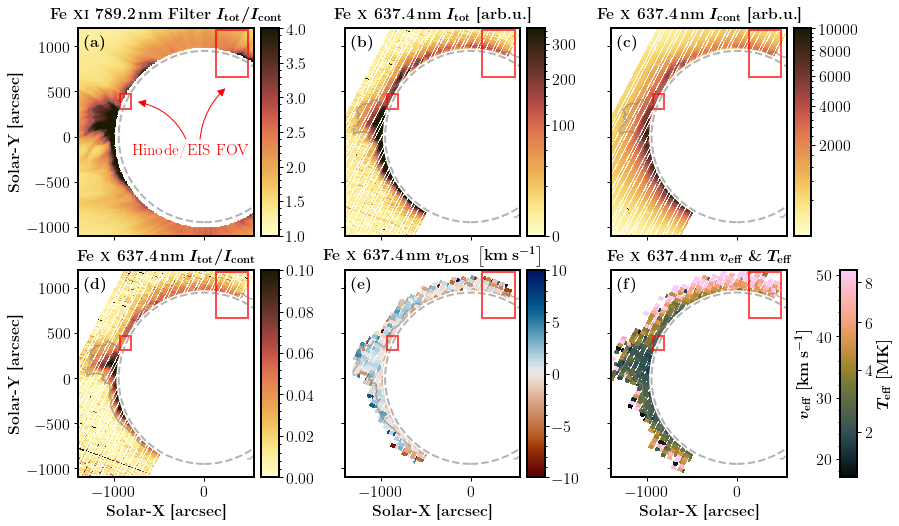

In [28]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(11.5,7.2),constrained_layout=True)
im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

plot_colorbar(im1, ax1,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

# for ax_ in (ax2,ax3,ax4,ax5,ax6):
#     ax_.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
#                         cmap=cmcm.lajolla,shading="auto",rasterized=True,alpha=0.6)

ax1.annotate(r"Hinode/EIS FOV",(-760,390),(-800,-200),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=0.3","color":"red"},fontsize=16,color="red")

ax1.annotate(r"",(250,550),(-50,-50),arrowprops={"arrowstyle":"-|>",
            "connectionstyle":"arc3,rad=-0.2","color":"red"},fontsize=16,color="red")

norm_red_line_int = ImageNormalize(red_line_int_masked,interval=ManualInterval(0,350),
                        stretch=SqrtStretch())

im2 = ax2.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_int_masked,cmap=cmcm.lajolla,rasterized=True,norm=norm_red_line_int)


plot_colorbar(im2, ax2,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

norm_red_cont_int = ImageNormalize(data=red_cont_masked,interval=ManualInterval(1e2,1e4),stretch=SqrtStretch())

im3 = ax3.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_cont_masked,cmap=cmcm.lajolla,rasterized=True,norm=norm_red_cont_int)

im3_clb, im3_clbax = plot_colorbar(im3, ax3,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)
# im3_clbax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# im3_clbax.yaxis.get_offset_text().set_fontsize(16)
# im3_clbax.yaxis.get_offset_text().set(va="bottom",ha="left")
# im3_clbax.yaxis.get_offset_text().set_position((0.4,1.3))

im4 = ax4.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.1)

plot_colorbar(im4, ax4,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im5 = ax5.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_vlos_masked,cmap=cmcm.vik_r,rasterized=True,vmin=-10,vmax=10)

plot_colorbar(im5, ax5,width=colorbar_width,bbox_to_anchor=(1.04, 0., 1, 1),fontsize=16)

im6 = ax6.pcolormesh(x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red,
                red_veff_masked,cmap=cmcm.batlowK,rasterized=True,vmin=0.06/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)),
                vmax=0.18/637.451*const.c.cgs.value*1e-5/np.sqrt(4*np.log(2)))

clb, clb_ax6 = plot_colorbar(im6, ax6,width=colorbar_width,bbox_to_anchor=(1.3, 0., 1, 1),fontsize=16)
clb_ax6.yaxis.set_ticks_position("left")
clb_ax6.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=16)
clb_ax6.yaxis.set_label_position("left")
clb_ax6_teff = clb_ax6.secondary_yaxis("right",functions=(veff2teff, teff2veff))
clb_ax6_teff.tick_params(labelsize=16)
clb_ax6_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=16)

ax1.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax4.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax4.set_ylabel(r"\textbf{Solar-Y [arcsec]}",fontsize=16)
ax5.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)
ax6.set_xlabel(r"\textbf{Solar-X [arcsec]}",fontsize=16)

ax1.set_title(r"\textbf{Fe \textsc{xi} 789.2\,nm Filter} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax2.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm tot}}$ \textbf{[arb.u.]}",fontsize=16,pad=10)
ax3.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm cont}}$ \textbf{[arb.u.]}",fontsize=16,pad=10)
ax4.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{I_{\rm tot}/I_{\rm cont}}$",fontsize=16,pad=10)
ax5.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{v_{\rm LOS}\ \left[\mathrm{km\,s^{-1}}\right]}$",fontsize=16,pad=10)
ax6.set_title(r"\textbf{Fe \textsc{x} 637.4\,nm} $\boldsymbol{v_{\rm eff}\ \&\ T_{\rm eff}}$",fontsize=16,pad=10)

for ax_, text_ in zip((ax1,ax2,ax3,ax4,ax5,ax6),
                      ("a","b","c","d","e","f")):
    ax_.text(0.035,0.97,r"\textbf{("+text_+r")}",fontsize=16,
             va="top",ha="left",transform=ax_.transAxes)
    
xlim_zoomin = [-1400,550]
ylim_zoomin = [-1100,1200]

for ax_ in (ax2,ax3,ax5,ax6):
    ax_.tick_params(labelleft=False)

for ax_ in (ax1,ax2,ax3):
    ax_.tick_params(labelbottom=False)

for ax_ in (ax1,ax2,ax3,ax4,ax5,ax6):
    ax_.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
    ax_.contour(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,levels=[3],alpha=0.6,
            colors=['grey'])
    plot_eis_fov(ax_,eis_atlas_30_fex_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}")
    plot_eis_fov(ax_,eis_ch_fex_intmap_shifted,color="red",alpha=0.7,
             label=r"\textbf{EIS}")
    ax_.add_patch(create_limb_circle(rsun_arcsec))
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=16)
    ax_.set_xlim(xlim_zoomin)
    ax_.set_ylim(ylim_zoomin)
fig.savefig(fname="../../figs/ms/FeX_fit.pdf",dpi=300,format="pdf",bbox_inches="tight")

In [29]:
FeX_in_atlas30_FOV = np.where( \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) > eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) < eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Tx.value + 32) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) > eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) < eis_atlas_30_fex_intmap_shifted.bottom_left_coord.Ty.value + 160))

In [30]:
red_veff_in_atlas30_FOV = red_veff_masked[FeX_in_atlas30_FOV]
red_veff_err_in_atlas30_FOV = red_veff_masked_err[FeX_in_atlas30_FOV]
red_veff_in_atlas30_FOV,red_veff_err_in_atlas30_FOV = np.unique([red_veff_in_atlas30_FOV,red_veff_err_in_atlas30_FOV],axis=1)
red_veff_in_atlas30_FOV = red_veff_in_atlas30_FOV[~np.isnan(red_veff_in_atlas30_FOV)]
red_veff_err_in_atlas30_FOV = red_veff_err_in_atlas30_FOV[~np.isnan(red_veff_err_in_atlas30_FOV)]

In [31]:
red_veff_in_atlas30_aver = np.nansum(red_veff_in_atlas30_FOV/red_veff_err_in_atlas30_FOV**2)/np.nansum(1./red_veff_err_in_atlas30_FOV**2)
red_veff_in_atlas30_aver_err = np.sqrt(1./(red_veff_in_atlas30_FOV.shape[0]-1)* \
(np.nansum(red_veff_in_atlas30_FOV**2/red_veff_err_in_atlas30_FOV**2)/np.nansum(1./red_veff_err_in_atlas30_FOV**2) - red_veff_in_atlas30_aver**2))

In [32]:
print("Average Fe X veff in Atlas 30 FOV: {:.2f} +/- {:.2f}".format(red_veff_in_atlas30_aver,red_veff_in_atlas30_aver_err))

Average Fe X veff in Atlas 30 FOV: 28.54 +/- 1.09


In [33]:
FeX_in_npch_r1_FOV = np.where( \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value + 156) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value + 512) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. >=1.03) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. <=1.08))

In [34]:
red_veff_in_npch_r1_FOV = red_veff_masked[FeX_in_npch_r1_FOV]
red_veff_err_in_npch_r1_FOV = red_veff_masked_err[FeX_in_npch_r1_FOV]
red_veff_in_npch_r1_FOV,red_veff_err_in_npch_r1_FOV = np.unique([red_veff_in_npch_r1_FOV,red_veff_err_in_npch_r1_FOV],axis=1)
red_veff_in_npch_r1_FOV = red_veff_in_npch_r1_FOV[~np.isnan(red_veff_in_npch_r1_FOV)]
red_veff_err_in_npch_r1_FOV = red_veff_err_in_npch_r1_FOV[~np.isnan(red_veff_err_in_npch_r1_FOV)]

In [35]:
red_veff_in_npch_r1_aver = np.nansum(red_veff_in_npch_r1_FOV/red_veff_err_in_npch_r1_FOV**2)/np.nansum(1./red_veff_err_in_npch_r1_FOV**2)
red_veff_in_npch_r1_aver_err = np.sqrt(1./(red_veff_in_npch_r1_FOV.shape[0]-1)* \
(np.nansum(red_veff_in_npch_r1_FOV**2/red_veff_err_in_npch_r1_FOV**2)/np.nansum(1./red_veff_err_in_npch_r1_FOV**2) - red_veff_in_npch_r1_aver**2))

In [36]:
print("Average Fe X veff in CH 1.03-1.08 Rsun FOV: {:.2f} +/- {:.2f}".format(red_veff_in_npch_r1_aver,red_veff_in_npch_r1_aver_err))

Average Fe X veff in CH 1.03-1.08 Rsun FOV: 40.05 +/- 0.58


In [37]:
FeX_in_npch_r2_FOV = np.where( \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value + 156) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value + 512) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. >=1.08) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. <=1.13))

red_veff_in_npch_r2_FOV = red_veff_masked[FeX_in_npch_r2_FOV]
red_veff_err_in_npch_r2_FOV = red_veff_masked_err[FeX_in_npch_r2_FOV]
red_veff_in_npch_r2_FOV,red_veff_err_in_npch_r2_FOV = np.unique([red_veff_in_npch_r2_FOV,red_veff_err_in_npch_r2_FOV],axis=1)
red_veff_in_npch_r2_FOV = red_veff_in_npch_r2_FOV[~np.isnan(red_veff_in_npch_r2_FOV)]
red_veff_err_in_npch_r2_FOV = red_veff_err_in_npch_r2_FOV[~np.isnan(red_veff_err_in_npch_r2_FOV)]

red_veff_in_npch_r2_aver = np.nansum(red_veff_in_npch_r2_FOV/red_veff_err_in_npch_r2_FOV**2)/np.nansum(1./red_veff_err_in_npch_r2_FOV**2)
red_veff_in_npch_r2_aver_err = np.sqrt(1./(red_veff_in_npch_r2_FOV.shape[0]-1)* \
(np.nansum(red_veff_in_npch_r2_FOV**2/red_veff_err_in_npch_r2_FOV**2)/np.nansum(1./red_veff_err_in_npch_r2_FOV**2) - red_veff_in_npch_r2_aver**2))

In [38]:
print("Average Fe X veff in CH 1.08-1.13 Rsun FOV: {:.2f} +/- {:.2f}".format(red_veff_in_npch_r2_aver,red_veff_in_npch_r2_aver_err))

Average Fe X veff in CH 1.08-1.13 Rsun FOV: 45.14 +/- 1.47


In [39]:
FeX_in_npch_r3_FOV = np.where( \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value) & \
((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Tx.value + 156) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) > eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value) & \
((y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red) < eis_ch_fex_intmap_shifted.bottom_left_coord.Ty.value + 512) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. >=1.13) & \
(np.sqrt((x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red)**2 + (y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)**2)/950. <=1.18))

red_veff_in_npch_r3_FOV = red_veff_masked[FeX_in_npch_r3_FOV]
red_veff_err_in_npch_r3_FOV = red_veff_masked_err[FeX_in_npch_r3_FOV]
red_veff_in_npch_r3_FOV,red_veff_err_in_npch_r3_FOV = np.unique([red_veff_in_npch_r3_FOV,red_veff_err_in_npch_r3_FOV],axis=1)
red_veff_in_npch_r3_FOV = red_veff_in_npch_r3_FOV[~np.isnan(red_veff_in_npch_r3_FOV)]
red_veff_err_in_npch_r3_FOV = red_veff_err_in_npch_r3_FOV[~np.isnan(red_veff_err_in_npch_r3_FOV)]

red_veff_in_npch_r3_aver = np.nansum(red_veff_in_npch_r3_FOV/red_veff_err_in_npch_r3_FOV**2)/np.nansum(1./red_veff_err_in_npch_r3_FOV**2)
red_veff_in_npch_r3_aver_err = np.sqrt(1./(red_veff_in_npch_r3_FOV.shape[0]-1)* \
(np.nansum(red_veff_in_npch_r3_FOV**2/red_veff_err_in_npch_r3_FOV**2)/np.nansum(1./red_veff_err_in_npch_r3_FOV**2) - red_veff_in_npch_r3_aver**2))

In [40]:
print("Average Fe X veff in CH 1.13-1.18 Rsun FOV: {:.2f} +/- {:.2f}".format(red_veff_in_npch_r3_aver,red_veff_in_npch_r3_aver_err))

Average Fe X veff in CH 1.13-1.18 Rsun FOV: 47.03 +/- 3.27


In [41]:
def find_nearest_pixel(x,y,x_grid,y_grid):
    distance = np.sqrt((x - x_grid)**2 + (y - y_grid)**2)
    index = np.unravel_index(np.argmin(distance),distance.shape)
    return index

In [42]:
def get_select_pixel_index(node_solarx, node_solary,xgrid,ygrid):
    node_xpixel, node_ypixel = np.zeros_like(node_solarx), np.zeros_like(node_solary)

    for ii in range(len(node_solarx)):
        node_ypixel[ii],node_xpixel[ii] = find_nearest_pixel(node_solarx[ii],node_solary[ii], 
            xgrid,ygrid)
    
    select_pixels_xindex = []
    select_pixels_yindex = []

    for ii in range(len(node_xpixel) - 1):
        rr, cc = skimage.draw.line(node_ypixel[ii],node_xpixel[ii],
                                node_ypixel[ii+1],node_xpixel[ii+1])
        
        select_pixels_xindex = np.concatenate((select_pixels_xindex,cc))
        select_pixels_yindex = np.concatenate((select_pixels_yindex,rr))

        index_tuple = tuple(np.stack((select_pixels_yindex,select_pixels_xindex),axis=-1).astype(np.int32).T)
        select_solarx = xgrid[index_tuple]
        select_solary = ygrid[index_tuple]
    
    return index_tuple, select_solarx, select_solary

In [43]:
def get_intensity(node_solarx, node_solary,xgrid,ygrid, intensity):
    node_xpixel, node_ypixel = np.zeros_like(node_solarx), np.zeros_like(node_solary)

    for ii in range(len(node_solarx)):
        node_ypixel[ii],node_xpixel[ii] = find_nearest_pixel(node_solarx[ii],node_solary[ii], 
            xgrid,ygrid)
        
    select_intensity = []
    for ii in range(len(node_xpixel) - 1):
        start = (node_ypixel[ii],node_xpixel[ii])
        end = (node_ypixel[ii+1],node_xpixel[ii+1])

        select_intensity_new = profile_line(intensity, start, end)

        select_intensity = np.concatenate((select_intensity,select_intensity_new))

    return select_intensity

In [44]:
south_streamer_index, south_streamer_solarx, south_streamer_solary = \
                        get_select_pixel_index([-700,-987,-1373],[-700,-707,-656],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

south_streamer_index_bin, south_streamer_solarx_bin, south_streamer_solary_bin = \
                        get_select_pixel_index([-700,-987,-1373],[-700,-707,-656],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

north_streamer_index_1, north_streamer_solarx_1, north_streamer_solary_1 = \
                        get_select_pixel_index([-937,-1051,-1440],[266,291,254],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

north_streamer_index_bin_1, north_streamer_solarx_bin_1, north_streamer_solary_bin_1 = \
                        get_select_pixel_index([-937,-1051,-1440],[266,291,254],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

north_streamer_index_2, north_streamer_solarx_2, north_streamer_solary_2 = \
                        get_select_pixel_index([-975,-1169,-1453],[55,21,-190],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

north_streamer_index_bin_2, north_streamer_solarx_bin_2, north_streamer_solary_bin_2 = \
                        get_select_pixel_index([-975,-1169,-1453],[55,21,-190],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

north_streamer_index_3, north_streamer_solarx_3, north_streamer_solary_3 = \
                        get_select_pixel_index([-910,-1100],[360,550],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

north_streamer_index_bin_3, north_streamer_solarx_bin_3, north_streamer_solary_bin_3 = \
                        get_select_pixel_index([-910,-1100],[360,550],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

In [45]:
def bin_same_data_points(image, image_err, select_index, select_solarx, select_solary):
    image_select = image[select_index]
    image_err_select = image_err[select_index]

    image_select_bin = []
    image_err_select_bin = []
    select_solarx_bin = []
    select_solary_bin = []

    n_pix = image_select.shape[0]
    ii = 0

    while ii < n_pix:
        if (ii < n_pix - 1) and (np.abs(image_select[ii] - image_select[ii+1]) < 1e-5):
            jj = 1
            while (ii+jj < n_pix - 1) and (image_select[ii+jj] == image_select[ii+jj+1]):
                jj = jj + 1
            image_select_bin.append(np.mean(image_select[ii:ii+jj+1]))
            image_err_select_bin.append(np.mean(image_err_select[ii:ii+jj+1]))
            select_solarx_bin.append(np.mean(select_solarx[ii:ii+jj+1]))
            select_solary_bin.append(np.mean(select_solary[ii:ii+jj+1]))

            ii = ii + jj + 1   
        else:
            image_select_bin.append(image_select[ii])
            image_err_select_bin.append(image_err_select[ii])
            select_solarx_bin.append(select_solarx[ii])
            select_solary_bin.append(select_solary[ii])

            ii = ii + 1

    return np.array(image_select_bin), np.array(image_err_select_bin), np.array(select_solarx_bin), np.array(select_solary_bin)

In [46]:
south_streamer_int, south_streamer_int_err, ss_int_solarx, ss_int_solary = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, south_streamer_index,
                      south_streamer_solarx, south_streamer_solary) 

south_streamer_veff, south_streamer_veff_err, ss_veff_solarx, ss_veff_solary = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, south_streamer_index_bin,
                      south_streamer_solarx_bin, south_streamer_solary_bin) 

In [47]:
north_streamer_int_1, north_streamer_int_err_1, ns_int_solarx_1, ns_int_solary_1 = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, north_streamer_index_1,
                      north_streamer_solarx_1, north_streamer_solary_1) 

north_streamer_veff_1, north_streamer_veff_err_1, ns_veff_solarx_1, ns_veff_solary_1 = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, north_streamer_index_bin_1,
                      north_streamer_solarx_bin_1, north_streamer_solary_bin_1) 

In [48]:
north_streamer_int_2, north_streamer_int_err_2, ns_int_solarx_2, ns_int_solary_2 = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, north_streamer_index_2,
                      north_streamer_solarx_2, north_streamer_solary_2) 

north_streamer_veff_2, north_streamer_veff_err_2, ns_veff_solarx_2, ns_veff_solary_2 = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, north_streamer_index_bin_2,
                      north_streamer_solarx_bin_2, north_streamer_solary_bin_2) 

In [49]:
north_streamer_int_3, north_streamer_int_err_3, ns_int_solarx_3, ns_int_solary_3 = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, north_streamer_index_3,
                      north_streamer_solarx_3, north_streamer_solary_3) 

north_streamer_veff_3, north_streamer_veff_err_3, ns_veff_solarx_3, ns_veff_solary_3 = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, north_streamer_index_bin_3,
                      north_streamer_solarx_bin_3, north_streamer_solary_bin_3) 

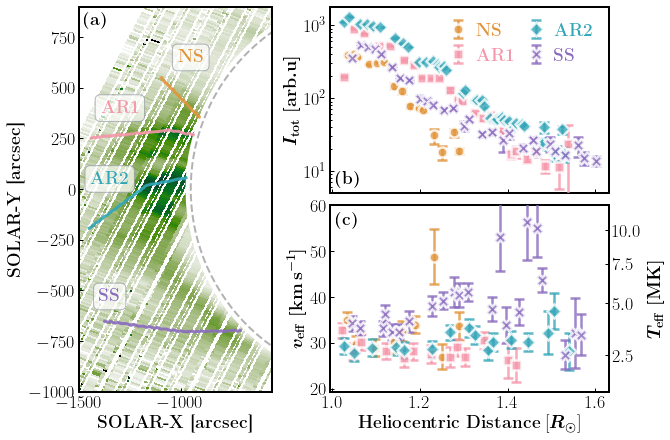

In [50]:
fig = plt.figure(figsize=(9.2,6),constrained_layout=True)
gs0 = fig.add_gridspec(1,2,width_ratios=[0.34,0.66])
gs1 = gs0[1].subgridspec(2,1)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs1[0])
ax3 = fig.add_subplot(gs1[1])

ax2.sharex(ax3)

im1 = ax1.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmr.jungle_r,rasterized=True,vmin=0,vmax=0.16)

ax1.plot(ss_int_solarx, ss_int_solary,color="#8A6BBE",alpha=0.9,lw=3)
ax1.plot(ns_int_solarx_1, ns_int_solary_1,color="#F596AA",alpha=0.9,lw=3)
ax1.plot(ns_int_solarx_2, ns_int_solary_2,color="#33A6B8",alpha=0.9,lw=3)
ax1.plot(ns_int_solarx_3, ns_int_solary_3,color="#E2943B",alpha=0.9,lw=3)

ax1.text(-950,650,r"\textbf{NS}",fontsize=18,color="#E2943B",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")
ax1.text(-1300,400,r"\textbf{AR1}",fontsize=18,color="#F596AA",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")
ax1.text(-1350,50,r"\textbf{AR2}",fontsize=18,color="#33A6B8",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")
ax1.text(-1350,-530,r"\textbf{SS}",fontsize=18,color="#8A6BBE",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
ax1.add_patch(create_limb_circle(rsun_arcsec))
ax1.set_aspect(1)
ax1.set_xlim(-1500,-550)
ax1.set_ylim(-1000,900)

ax1.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=18)
ax1.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=18)

ax1.text(0.02,0.99,r"\textbf{(a)}",fontsize=18,va="top",ha="left",
         transform=ax1.transAxes)


ax2.errorbar(np.sqrt(ns_int_solarx_3**2 + ns_int_solary_3**2)/rsun_arcsec,
             north_streamer_int_3, north_streamer_int_err_3, color="#E2943B",ls="none",marker="o",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{NS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.errorbar(np.sqrt(ns_int_solarx_1**2 + ns_int_solary_1**2)/rsun_arcsec,
             north_streamer_int_1, north_streamer_int_err_1, color="#F596AA",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR1}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.errorbar(np.sqrt(ns_int_solarx_2**2 + ns_int_solary_2**2)/rsun_arcsec,
             north_streamer_int_2, north_streamer_int_err_2, color="#33A6B8",ls="none",marker="D",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR2}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.errorbar(np.sqrt(ss_int_solarx**2 + ss_int_solary**2)/rsun_arcsec,
             south_streamer_int, south_streamer_int_err, color="#8A6BBE",ls="none",marker="X",
            markersize=12,capsize=5,lw=2.5,label=r"\textbf{SS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.set_yscale("log")
ax2.set_ylim(bottom=5)
ax2.legend(fontsize=18,ncol=2,loc="upper right",frameon=False,labelcolor=["#E2943B","#F596AA","#33A6B8","#8A6BBE"],
          columnspacing=0.2,handletextpad=0)

ax2.set_ylabel(r"$\boldsymbol{I_{\rm tot}\ [\mathrm{arb.u}]}$",fontsize=18)
ax2.tick_params(labelbottom=False)

ax2.text(0.02,0.03,r"\textbf{(b)}",fontsize=18,va="bottom",ha="left",
         transform=ax2.transAxes)

ax3.errorbar(np.sqrt(ns_veff_solarx_3**2 + ns_veff_solary_3**2)/rsun_arcsec,
             north_streamer_veff_3, north_streamer_veff_err_3, color="#E2943B",ls="none",marker="o",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{NS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(ns_veff_solarx_1**2 + ns_veff_solary_1**2)/rsun_arcsec,
             north_streamer_veff_1, north_streamer_veff_err_1, color="#F596AA",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR1}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(ns_veff_solarx_2**2 + ns_veff_solary_2**2)/rsun_arcsec,
             north_streamer_veff_2, north_streamer_veff_err_2, color="#33A6B8",ls="none",marker="D",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR2}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(ss_veff_solarx**2 + ss_veff_solary**2)/rsun_arcsec,
             south_streamer_veff, south_streamer_veff_err, color="#8A6BBE",ls="none",marker="X",
            markersize=12,capsize=5,lw=2.5,label=r"\textbf{SS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.set_ylim(top=60)
ax3.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=18)

ax3_teff = ax3.secondary_yaxis(location="right",functions=(veff2teff, teff2veff))
ax3_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=18)
ax3.set_xlabel(r"\textbf{Heliocentric Distance} $\left[\boldsymbol{R_\odot}\right]$",fontsize=18)

ax3.text(0.02,0.97,r"\textbf{(c)}",fontsize=18,va="top",ha="left",
         transform=ax3.transAxes)


for ax_ in (ax1,ax2,ax3,ax3_teff):
    ax_.tick_params(labelsize=18,direction="in",which="both")

plt.savefig(fname="../../figs/ms/FeXIV_raytrace.pdf",format="pdf",dpi=300,bbox_inches="tight")




In [65]:
koutchmy_slit1_index, koutchmy_slit1_solarx, koutchmy_slit1_solary = \
                        get_select_pixel_index([-965, -1406],[164, -454],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

koutchmy_slit1_index_bin, koutchmy_slit1_solarx_bin, koutchmy_slit1_solary_bin = \
                        get_select_pixel_index([-965, -1406],[164, -454],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

koutchmy_slit4_index, koutchmy_slit4_solarx, koutchmy_slit4_solary = \
                        get_select_pixel_index([-943, -1274],[-261, -725],
                        x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_rot_ext + slit_center_y_green)

koutchmy_slit4_index_bin, koutchmy_slit4_solarx_bin, koutchmy_slit4_solary_bin = \
                        get_select_pixel_index([-943, -1274],[-261, -725],
                        x_2d_grid_green_arcsec_bin_rot_ext + slit_center_x_green,
                        y_2d_grid_green_arcsec_bin_rot_ext + slit_center_y_green)

In [66]:
koutchmy_slit1_int, koutchmy_slit1_int_err, ks1_int_solarx, ks1_int_solary = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, koutchmy_slit1_index,
                      koutchmy_slit1_solarx, koutchmy_slit1_solary) 

koutchmy_slit1_veff, koutchmy_slit1_veff_err, ks1_veff_solarx, ks1_veff_solary = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, koutchmy_slit1_index_bin,
                      koutchmy_slit1_solarx_bin, koutchmy_slit1_solary_bin) 

koutchmy_slit4_int, koutchmy_slit4_int_err, ks4_int_solarx, ks4_int_solary = \
bin_same_data_points(green_line_int_masked, green_line_int_masked_err, koutchmy_slit4_index,
                      koutchmy_slit4_solarx, koutchmy_slit4_solary) 

koutchmy_slit4_veff, koutchmy_slit4_veff_err, ks4_veff_solarx, ks4_veff_solary = \
bin_same_data_points(green_veff_masked, green_veff_masked_err, koutchmy_slit4_index_bin,
                      koutchmy_slit4_solarx_bin, koutchmy_slit4_solary_bin) 

In [67]:
koutchmy_slit4_df = pd.read_excel("../../sav/Koutchmy_Digitize/slit_pos.xlsx",sheet_name="slit4")
digitized_koutchmy_slit4_veff = koutchmy_slit4_df["fwhm"]/5302.9/np.sqrt(4*np.log(2))*const.c.cgs.value*1e-5
digitized_koutchmy_slit4_veff_err = np.abs(koutchmy_slit4_df["fwhm"]-koutchmy_slit4_df["yerr"])/5302.9/np.sqrt(4*np.log(2))*const.c.cgs.value*1e-5
digitized_koutchmy_slit4_height_err = np.abs(koutchmy_slit4_df["height"] - koutchmy_slit4_df["xerr"])

In [68]:
koutchmy_slit1_df = pd.read_excel("../../sav/Koutchmy_Digitize/slit_pos.xlsx",sheet_name="slit1")
digitized_koutchmy_slit1_veff = koutchmy_slit1_df["fwhm"]/5302.9/np.sqrt(4*np.log(2))*const.c.cgs.value*1e-5

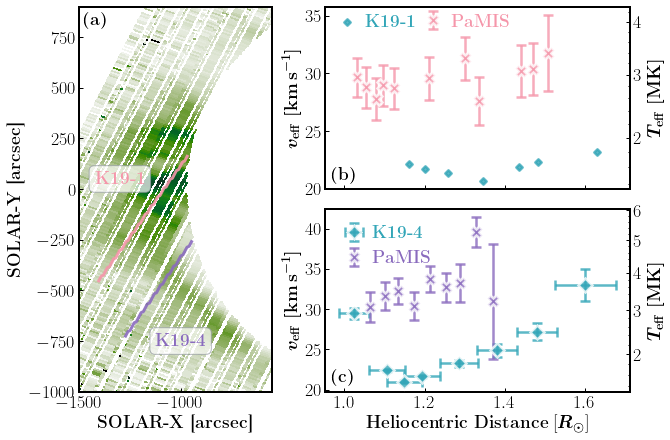

In [69]:
fig = plt.figure(figsize=(9.2,6),constrained_layout=True)
gs0 = fig.add_gridspec(1,2,width_ratios=[0.34,0.66])
gs1 = gs0[1].subgridspec(2,1)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs1[0])
ax3 = fig.add_subplot(gs1[1])

ax2.sharex(ax3)

im1 = ax1.pcolormesh(x_2d_grid_green_arcsec_rot_ext + slit_center_x_green,
                y_2d_grid_green_arcsec_rot_ext + slit_center_y_green,
                green_line_cont_ratio_masked,cmap=cmr.jungle_r,rasterized=True,vmin=0,vmax=0.16)

ax1.plot(ks1_int_solarx, ks1_int_solary,color="#F596AA",alpha=0.9,lw=3)
ax1.plot(ks4_int_solarx, ks4_int_solary,color="#8A6BBE",alpha=0.9,lw=3)

ax1.text(-1300,50,r"\textbf{K19-1}",fontsize=18,color="#F596AA",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.text(-1000,-750,r"\textbf{K19-4}",fontsize=18,color="#8A6BBE",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.set_aspect(1)
ax1.set_xlim(-1500,-550)
ax1.set_ylim(-1000,900)

ax1.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=18)
ax1.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=18)

ax1.text(0.02,0.99,r"\textbf{(a)}",fontsize=18,va="top",ha="left",
         transform=ax1.transAxes)

ax2.scatter(koutchmy_slit1_df["height"], digitized_koutchmy_slit1_veff,color="#33A6B8",marker="D",
            s=20,label=r"\textbf{K19-1}",zorder=15,
            linewidths=2.5,alpha=0.8)


ax2.errorbar(np.sqrt(ks1_veff_solarx**2 + ks1_veff_solary**2)/rsun_arcsec,
             koutchmy_slit1_veff, koutchmy_slit1_veff_err, color="#F596AA",ls="none",marker="X",
            markersize=12,capsize=5,lw=2.5,label=r"\textbf{PaMIS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.legend(fontsize=18,ncol=2,frameon=False,labelcolor=["#33A6B8","#F596AA"],
          columnspacing=0,handletextpad=0,bbox_to_anchor=[0.16,0.75,0.5,0.3])

ax2.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=18)

ax2_teff = ax2.secondary_yaxis(location="right",functions=(veff2teff, teff2veff))
ax2_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=18)
ax2.tick_params(labelbottom=False)

ax2.text(0.02,0.03,r"\textbf{(b)}",fontsize=18,va="bottom",ha="left",
         transform=ax2.transAxes)

ax3.errorbar(koutchmy_slit4_df["height"], digitized_koutchmy_slit4_veff, xerr=digitized_koutchmy_slit4_height_err, 
             yerr=digitized_koutchmy_slit4_veff_err,color="#33A6B8",ls="none",marker="D",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{K19-4}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(ks4_veff_solarx**2 + ks4_veff_solary**2)/rsun_arcsec,
             koutchmy_slit4_veff, koutchmy_slit4_veff_err, color="#8A6BBE",ls="none",marker="X",
            markersize=12,capsize=5,lw=2.5,label=r"\textbf{PaMIS}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=18)

ax3_teff = ax3.secondary_yaxis(location="right",functions=(veff2teff, teff2veff))
ax3_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=18)
ax3.set_xlabel(r"\textbf{Heliocentric Distance} $\left[\boldsymbol{R_\odot}\right]$",fontsize=18)

ax3.text(0.02,0.03,r"\textbf{(c)}",fontsize=18,va="bottom",ha="left",
         transform=ax3.transAxes)

ax3.legend(fontsize=18,frameon=False,labelcolor=["#33A6B8","#8A6BBE"],
          columnspacing=0,handletextpad=0,bbox_to_anchor=[0,0.6,0.4,0.4])


for ax_ in (ax1,ax2,ax3,ax2_teff,ax3_teff):
    ax_.tick_params(labelsize=18,direction="in",which="both")

for ax_ in (ax2_teff, ax3_teff):
    ax_.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(fname="../../figs/ms/FeXIV_K19.pdf",format="pdf",dpi=300,bbox_inches="tight")



In [56]:
red_active_region_index_1, red_active_region_solarx_1, red_active_region_solary_1 = \
                        get_select_pixel_index([-940,-1250],[220,300],
                        x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)

red_active_region_index_bin_1, red_active_region_solarx_bin_1, red_active_region_solary_bin_1 = \
                        get_select_pixel_index([-940,-1250],[220,300],
                        x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)

red_active_region_index_2, red_active_region_solarx_2, red_active_region_solary_2 = \
                        get_select_pixel_index([-950,-1250],[200,90],
                        x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)

red_active_region_index_bin_2, red_active_region_solarx_bin_2, red_active_region_solary_bin_2 = \
                        get_select_pixel_index([-950,-1250],[200,90],
                        x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)

red_coronal_hole_index, red_coronal_hole_solarx, red_coronal_hole_solary = \
                        get_select_pixel_index([-35,90],[980,1250],
                        x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_rot_ext + slit_center_y_red)

red_coronal_hole_index_bin, red_coronal_hole_solarx_bin, red_coronal_hole_solary_bin = \
                        get_select_pixel_index([-35,90],[980,1250],
                        x_2d_grid_red_arcsec_bin_rot_ext + slit_center_x_red,
                        y_2d_grid_red_arcsec_bin_rot_ext + slit_center_y_red)

In [57]:
red_active_region_int_1, red_active_region_int_err_1, rar_int_solarx_1, rar_int_solary_1 = \
bin_same_data_points(red_line_int_masked, red_line_int_masked_err, red_active_region_index_1,
                      red_active_region_solarx_1, red_active_region_solary_1) 

red_active_region_veff_1, red_active_region_veff_err_1, rar_veff_solarx_1, rar_veff_solary_1 = \
bin_same_data_points(red_veff_masked, red_veff_masked_err, red_active_region_index_bin_1,
                      red_active_region_solarx_bin_1, red_active_region_solary_bin_1) 

red_active_region_int_2, red_active_region_int_err_2, rar_int_solarx_2, rar_int_solary_2 = \
bin_same_data_points(red_line_int_masked, red_line_int_masked_err, red_active_region_index_2,
                      red_active_region_solarx_2, red_active_region_solary_2) 

red_active_region_veff_2, red_active_region_veff_err_2, rar_veff_solarx_2, rar_veff_solary_2 = \
bin_same_data_points(red_veff_masked, red_veff_masked_err, red_active_region_index_bin_2,
                      red_active_region_solarx_bin_2, red_active_region_solary_bin_2) 

red_coronal_hole_int, red_coronal_hole_int_err, rch_int_solarx, rch_int_solary = \
bin_same_data_points(red_line_int_masked, red_line_int_masked_err, red_coronal_hole_index,
                      red_coronal_hole_solarx, red_coronal_hole_solary) 

red_coronal_hole_veff, red_coronal_hole_veff_err, rch_veff_solarx, rch_veff_solary = \
bin_same_data_points(red_veff_masked, red_veff_masked_err, red_coronal_hole_index_bin,
                      red_coronal_hole_solarx_bin, red_coronal_hole_solary_bin) 

In [58]:
red_coronal_hole_int[np.where(np.abs(red_coronal_hole_int_err/red_coronal_hole_int) > 1)] = np.nan

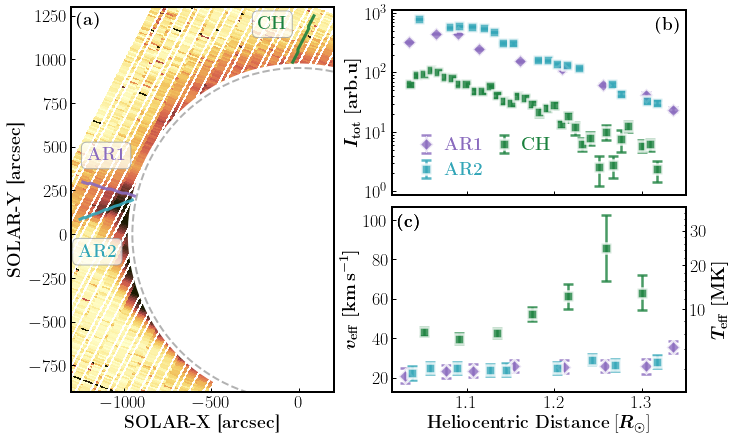

In [59]:
fig = plt.figure(figsize=(10.1,6),constrained_layout=True)
gs0 = fig.add_gridspec(1,2,width_ratios=[0.4,0.6])
gs1 = gs0[1].subgridspec(2,1)

ax1 = fig.add_subplot(gs0[0])
ax2 = fig.add_subplot(gs1[0])
ax3 = fig.add_subplot(gs1[1])

ax2.sharex(ax3)

im1 = ax1.pcolormesh(x_2d_grid_red_arcsec_rot_ext + slit_center_x_red,
                y_2d_grid_red_arcsec_rot_ext + slit_center_y_red,
                red_line_cont_ratio_masked,cmap=cmcm.lajolla,rasterized=True,vmin=0,vmax=0.1)

ax1.plot(rar_int_solarx_1, rar_int_solary_1,color="#8A6BBE",alpha=0.9,lw=3)
ax1.plot(rar_int_solarx_2, rar_int_solary_2,color="#33A6B8",alpha=0.9,lw=3)
ax1.plot(rch_int_solarx, rch_int_solary,color="#1B813E",alpha=0.9,lw=3)
# ax1.plot(ns_int_solarx_3, ns_int_solary_3,color="#E2943B",alpha=0.9,lw=3)

ax1.text(-1100,450,r"\textbf{AR1}",fontsize=18,color="#8A6BBE",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.text(-1150,-100,r"\textbf{AR2}",fontsize=18,color="#33A6B8",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.text(-150,1200,r"\textbf{CH}",fontsize=18,color="#1B813E",bbox=dict(boxstyle="round", fc="w",ec="#91989F",alpha=0.7),
         va="center",ha="center")

ax1.add_patch(create_lunar_mask(rsun_arcsec*np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])))
ax1.add_patch(create_limb_circle(rsun_arcsec))
ax1.set_aspect(1)
ax1.set_xlim(-1300,200)
ax1.set_ylim(-900,1300)
ax1.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=18)
ax1.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=18)

ax1.text(0.02,0.99,r"\textbf{(a)}",fontsize=18,va="top",ha="left",
         transform=ax1.transAxes)
ax2.errorbar(np.sqrt(rar_int_solarx_1**2 + rar_int_solary_1**2)/rsun_arcsec,
             red_active_region_int_1, red_active_region_int_err_1, color="#8A6BBE",ls="none",marker="D",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR1}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.errorbar(np.sqrt(rar_int_solarx_2**2 + rar_int_solary_2**2)/rsun_arcsec,
             red_active_region_int_2, red_active_region_int_err_2, color="#33A6B8",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR2}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.errorbar(np.sqrt(rch_int_solarx**2 + rch_int_solary**2)/rsun_arcsec,
             red_coronal_hole_int, red_coronal_hole_int_err, color="#1B813E",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{CH}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax2.set_yscale("log")
ax2.legend(fontsize=18,ncol=2,loc="lower left",frameon=False,labelcolor=["#8A6BBE","#33A6B8","#1B813E"],
          columnspacing=0.2,handletextpad=0)
ax2.set_ylabel(r"$\boldsymbol{I_{\rm tot}\ [\mathrm{arb.u}]}$",fontsize=18)
ax2.tick_params(labelbottom=False)

ax2.text(0.98,0.97,r"\textbf{(b)}",fontsize=18,va="top",ha="right",
         transform=ax2.transAxes)

ax3.errorbar(np.sqrt(rar_veff_solarx_1**2 + rar_veff_solary_1**2)/rsun_arcsec,
             red_active_region_veff_1, red_active_region_veff_err_1, color="#8A6BBE",ls="none",marker="D",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR1}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(rar_veff_solarx_2**2 + rar_veff_solary_2**2)/rsun_arcsec,
             red_active_region_veff_2, red_active_region_veff_err_2, color="#33A6B8",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{AR2}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.errorbar(np.sqrt(rch_veff_solarx**2 + rch_veff_solary**2)/rsun_arcsec,
             red_coronal_hole_veff, red_coronal_hole_veff_err, color="#1B813E",ls="none",marker="s",
            markersize=10,capsize=5,lw=2.5,label=r"\textbf{CH}",zorder=15,markeredgecolor='white',
            markeredgewidth=2.5,alpha=0.8,capthick=2.5)

ax3.set_ylabel(r"$\boldsymbol{v_{\rm eff}\ [\mathrm{km\,s^{-1}}]}$",fontsize=18)

ax3_teff = ax3.secondary_yaxis(location="right",functions=(veff2teff, teff2veff))
ax3_teff.set_ylabel(r"$\boldsymbol{T_{\rm eff}\ [\mathrm{MK}]}$",fontsize=18)
ax3_teff.yaxis.set_minor_locator(AutoMinorLocator())
ax3.set_xlabel(r"\textbf{Heliocentric Distance} $\left[\boldsymbol{R_\odot}\right]$",fontsize=18)

ax3.text(0.02,0.97,r"\textbf{(c)}",fontsize=18,va="top",ha="left",
         transform=ax3.transAxes)
ax3.text(0.02,0.97,r"\textbf{(c)}",fontsize=18,va="top",ha="left",
         transform=ax3.transAxes)

for ax_ in (ax1,ax2,ax3,ax3_teff):
    ax_.tick_params(labelsize=18,direction="in",which="both")

plt.savefig(fname="../../figs/ms/FeX_raytrace.pdf",format="pdf",dpi=300,bbox_inches="tight")


